**IMPORTS**

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

**DATA IMPORT and PREP**

In [150]:
df =  pd.read_csv('./dffinal.csv')

In [151]:
df.head()

,date,open consumer discretionary,close consumer discretionary,low consumer discretionary,high consumer discretionary,volume consumer discretionary,open industrials,close industrials,low industrials,high industrials,...,close health,low health,high health,volume health,open utilities,close utilities,low utilities,high utilities,volume utilities,VIX Close
0,2006-02-06,72.775002,72.399999,71.834998,73.345000,20881200,96.869999,95.920002,95.010002,97.529999,...,81.290003,80.990002,82.180000,38586900,106.390003,107.010000,105.920002,107.280003,3943300,13.04
1,2006-02-07,72.414999,71.985001,71.624998,72.880000,21343500,95.910002,94.300003,92.559999,96.080002,...,81.329998,80.870003,82.800003,43082300,106.880001,106.709999,105.889997,107.720001,8455900,13.59
2,2006-02-08,72.325000,72.639999,71.894999,72.744998,29281000,92.870001,94.730001,92.119999,95.950003,...,83.400002,81.590000,83.670000,78337500,107.520000,107.610001,106.410000,107.750000,7349000,12.83
3,2006-02-09,72.954999,72.855001,72.590001,73.450001,23437700,92.529999,97.769999,91.819998,98.500000,...,83.270000,83.070000,84.350000,61646500,107.670000,108.390001,107.189999,108.800001,6477300,13.12
4,2006-02-10,73.025000,72.690001,72.159999,73.485002,21519000,97.339996,97.520000,96.209997,99.439999,...,82.390001,81.230000,83.040001,72039700,108.260000,108.160002,107.090002,109.110001,6055000,12.87


In [152]:
df.shape

(3160, 57)

In [153]:
#checking nulls
df.isnull().sum()

0

In [154]:
#changing date column using to_datetime
df['date'] = pd.to_datetime(df['date'])

In [155]:
#sorting by date index
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [156]:
df.shape

(3160, 56)

We need to assign all of our predictor columns to our X variable and our VIX closing price to our y. This will allow us to properly and cleanly set up a train-test-split.

In [157]:
features = [col for col in df.columns if not col == 'VIX Close']
X = df[features]
y = df[['VIX Close']].values

In [158]:
#changing our predictors to percent change
X = X.pct_change()

In [159]:
y = np.delete(y, 0)

In [160]:
X.dropna(inplace=True)

In [161]:
X.shape

(3159, 55)

In [162]:
y.shape

(3159,)

In [163]:
#setting up our train test split without shuffling so we can keep data ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_train.head()

,open consumer discretionary,close consumer discretionary,low consumer discretionary,high consumer discretionary,volume consumer discretionary,open industrials,close industrials,low industrials,high industrials,volume industrials,...,open health,close health,low health,high health,volume health,open utilities,close utilities,low utilities,high utilities,volume utilities
date,,,,,,,,,,,,,,,,,,,,,
2006-02-07,-0.004947,-0.005732,-0.002923,-0.006340,0.022140,-0.009910,-0.016889,-0.025787,-0.014867,0.578955,...,-0.010620,0.000492,-0.001482,0.007544,0.116501,0.004606,-0.002803,-0.000283,0.004101,1.144371
2006-02-08,-0.001243,0.009099,0.003770,-0.001852,0.371893,-0.031696,0.004560,-0.004754,-0.001353,-0.096751,...,0.010487,0.025452,0.008903,0.010507,0.818322,0.005988,0.008434,0.004911,0.000278,-0.130903
2006-02-09,0.008711,0.002960,0.009667,0.009691,-0.199559,-0.003661,0.032091,-0.003257,0.026576,-0.049278,...,0.020147,-0.001559,0.018139,0.008127,-0.213065,0.001395,0.007248,0.007330,0.009745,-0.118615
2006-02-10,0.000960,-0.002265,-0.005924,0.000477,-0.081864,0.051983,-0.002557,0.047811,0.009543,-0.160729,...,-0.016397,-0.010568,-0.022150,-0.015531,0.168594,0.005480,-0.002122,-0.000933,0.002849,-0.065197
2006-02-13,-0.004724,-0.007635,-0.006098,-0.009798,-0.217952,0.029998,0.019893,0.019229,0.023532,-0.121736,...,-0.001947,0.004976,0.003324,0.002649,-0.441626,-0.002494,-0.006564,0.001027,-0.007699,-0.438035


In [164]:
X_train.shape

(2369, 55)

In [165]:
# checking to make sure last day of training data is the day before the start of testing data
X_train.index[-1], X_test.index[0]

(Timestamp('2015-07-08 00:00:00'), Timestamp('2015-07-09 00:00:00'))

In [166]:
#since we are going to be using RNN's it is imperative that we scale our data. We should do this anyway because we ccould
#see from our EDA that the values were sometimes on different scales. We will transform all of our predictor values.
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [167]:
#setting up our time series sequences on our scaled data since this is a time series issue. We will use a batchsize of 64
#and with a length of 3
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [168]:
batch_x, batch_y = train_sequences[0]

In [169]:
batch_x.shape

(64, 3, 55)

In [170]:
batch_y.shape

(64,)

In [171]:
batch_x[0]

array([[-0.29453321, -0.33790094, -0.19299733, -0.43696688, -0.10334733,
        -0.37033996, -0.61987111, -0.96692254, -0.64714447,  1.40544304,
        -0.31799019, -2.84405881, -2.49918499, -1.20822226,  2.18576398,
         0.02235674, -1.7945687 , -1.69832722, -1.12643366,  0.25675758,
        -0.08340259, -0.08341076, -0.06272336,  0.53896995,  1.1667532 ,
         0.41059841, -0.29350491, -0.04106176, -0.64383973,  5.2871253 ,
         0.53122448,  1.41281682,  0.38844487,  1.75935289,  1.98557473,
         0.68538673,  0.10595628,  0.61139648, -0.09027604, -0.58969795,
         0.00623837, -0.0230749 ,  0.01094938,  0.10524294,  0.28899137,
        -0.83772105,  0.00908427, -0.14493931,  0.64837899,  0.22962268,
         0.31307611, -0.21115089, -0.03905582,  0.32559983,  3.03554248],
       [-0.09115043,  0.47743293,  0.19563775, -0.14461888,  0.70814696,
        -1.14667139,  0.14555423, -0.19204737, -0.07300542, -0.39761556,
        -1.91236097, -0.36487243, -0.885042  , -2.

In [172]:
pd.DataFrame(X_train_sc, columns=X_train.columns)

,open consumer discretionary,close consumer discretionary,low consumer discretionary,high consumer discretionary,volume consumer discretionary,open industrials,close industrials,low industrials,high industrials,volume industrials,...,open health,close health,low health,high health,volume health,open utilities,close utilities,low utilities,high utilities,volume utilities
0,-0.294533,-0.337901,-0.192997,-0.436967,-0.103347,-0.370340,-0.619871,-0.966923,-0.647144,1.405443,...,-0.837721,0.009084,-0.144939,0.648379,0.229623,0.313076,-0.211151,-0.039056,0.325600,3.035542
1,-0.091150,0.477433,0.195638,-0.144619,0.708147,-1.146671,0.145554,-0.192047,-0.073005,-0.397616,...,0.771693,1.880855,0.670954,0.915108,2.384455,0.412213,0.567919,0.356891,0.005399,-0.506541
2,0.455391,0.139929,0.538068,0.607426,-0.617731,-0.147659,1.128032,-0.136895,1.113552,-0.270939,...,1.508187,-0.144705,1.396617,0.700840,-0.782258,0.082825,0.485719,0.541319,0.798281,-0.472412
3,0.029778,-0.147291,-0.367215,0.007103,-0.344655,1.835167,-0.108419,1.744471,0.389910,-0.568337,...,-1.278227,-0.820320,-1.768772,-1.428997,0.389566,0.375758,-0.163903,-0.088576,0.220722,-0.324043
4,-0.282321,-0.442526,-0.377308,-0.662246,-0.660404,1.051748,0.692743,0.691485,0.984207,-0.464287,...,-0.176406,0.345369,0.232616,0.207682,-1.484017,-0.196086,-0.471882,0.060840,-0.662753,-1.359603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,0.023044,0.596136,0.249591,0.505227,0.084643,0.263918,-0.724796,-1.583692,0.008887,0.746112,...,-0.601756,0.908381,0.172945,0.669088,-0.591637,-0.071825,0.267574,0.131468,-0.116025,-0.877740
2365,0.248405,-0.235121,0.185988,0.030021,-1.058074,-1.124067,0.031569,0.501695,-0.977353,-1.153954,...,1.240103,-0.235384,0.880819,0.765327,-0.722929,0.459656,1.087220,0.762894,1.368608,-0.603340
2366,-0.783001,-0.219228,-0.542252,-0.347448,0.431609,0.004009,0.767670,0.411906,0.497925,-0.077388,...,-0.907285,-0.131888,-0.753646,-0.691269,-0.246876,0.510786,0.096603,0.113907,0.152569,-0.014585
2367,0.335100,0.904222,0.111031,0.577039,0.298609,0.779243,0.447173,0.108678,0.403719,0.245767,...,0.586057,0.753842,0.317351,0.341301,0.287155,0.227709,1.497396,0.764152,1.989822,2.456539


In [173]:
#repeating our above steps on our scaled testing data with equal batch size and length
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [174]:
train_sequences[0][0].shape

(64, 3, 55)

In [175]:
#assigning our input_shape so that we can pass that value in our models
input_shape = train_sequences[0][0][0].shape
input_shape

(3, 55)

**MODELS**

We will be using a series of different neural network models. We would choose this model because of the size of our initial dataset and because we don't have a major intuition of what variables what might be relevant. The problems with this method is that we lose out on some interpretability compared to other modeling choices, but we can hopefully discover some more meaningful relationships that might be missed by supervised methods. Since our problem is concerned with predicting the actual value of the VIX at close, we will be using MSE for our loss functions since this is well suited for the problem. Specifically our metric of interest will be MSE so we can analyze how far off we are from the actual predicted value putting a heavy penalty on outliers since their value is squared.

In [176]:
#initial GRU model. Effectively an LSTM that allows for some memory loss. Contains 1 hidden layer with relu activation
#and an output layer with relu activation
model = Sequential()
model.add(GRU(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model.add(GRU(8, return_sequences=False))                         # False if next layer is Dense

model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))

In [177]:
#compiled using MSE as our loss function and Adam optimizer
model.compile(optimizer = Adam(lr=0.0005), loss = 'mean_squared_error')

#assigning our fit to history using our training and validating on our test sequences
history = model.fit(train_sequences, validation_data=test_sequences, epochs=100, verbose=0)

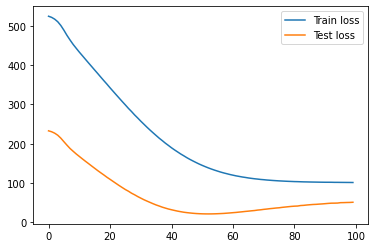

In [178]:
#results from our first model
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

In [179]:
ypreds = model.predict(test_sequences)

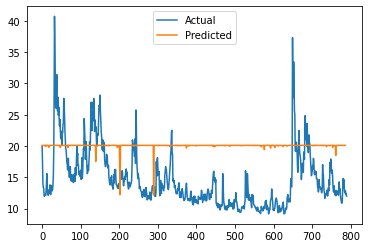

In [187]:
plt.plot(y_test, label='Actual')
plt.plot(ypreds, label='Predicted')
plt.legend();

We can see that there does seem to be decent training speed and there is some agreement between trainign and testing as far as loss goes; however, when we chart our predicted values to our actual values our model did not really do much. It sat right around 20 and did not predict much change at all. We will instead try to linearize the output layer and change the input function to a generic Dense layer.

In [181]:
#second model with dense input of size 24 neurons, a hidden dense layer with relu activation of 8 neurons, and a 
#dense output layer with generic linear activation
model2 = Sequential()
model2.add(Dense(24,
               input_shape = input_shape,
               activation = 'relu'))
model2.add(Dense(8, activation = 'relu'))
model2.add(Dense(1, activation = 'linear'))

In [183]:
model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [184]:
history2 = model2.fit(train_sequences, validation_data=test_sequences, epochs=100, verbose=0)

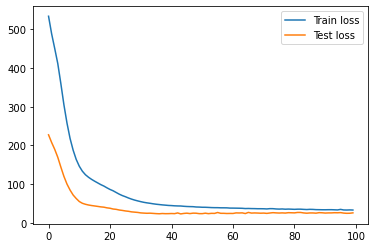

In [185]:
plt.plot(history2.history['loss'], label='Train loss')
plt.plot(history2.history['val_loss'], label='Test loss')
plt.legend();

This model looks considerably better as we are getting very close to convergence at around the 100 Epoch mark. Additionally whereas the original model had stopped improving around an MSE of 100, this model appears to be considerably lower. We can see if we can get a quicker training model with a lower score by making it more complicated and adding in an additional dropout layer, increasing the input layer size, and changing our input layer to LSTM to take advantage of a fully connected neural network layer and its strength with memory.

In [213]:
#Our third model featuring a larger input layer of LSTM type to leverage the memory advantage with 2 dropout layers
#both with relu activation and a linear output layer.
model3 = Sequential()
model3.add(LSTM(64, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model3.add(LSTM(8, return_sequences=False))  # False if next layer is Dense
model3.add(Dense(16, activation='relu'))
model3.add(Dense(4, activation='relu'))
model3.add(Dense(1, activation='linear'))

In [214]:
#using more epochs to see if we can capture any odd behavior beyond our 100 epochs
model3.compile(optimizer = 'adam', loss = 'mse')
history3 = model3.fit(train_sequences, validation_data=test_sequences, epochs=200, verbose=0)

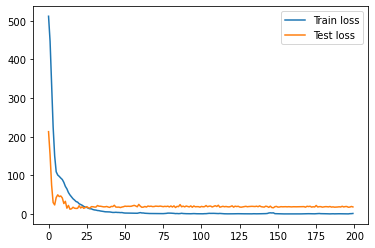

In [215]:
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Test loss')
plt.legend();

In [216]:
ypreds3=model3.predict(test_sequences)

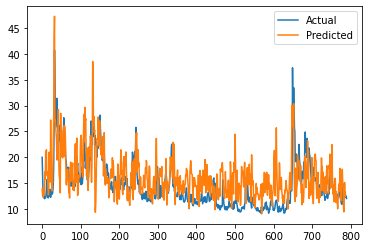

In [217]:
plt.plot(y_test, label='Actual')
plt.plot(ypreds3, label='Predicted')
plt.legend();

Our third model certainly seems to converge around 25 epochs and does not do much from there, but it does appear to be overfittign which is to be expected in neural networks. However, the LSTM does seem to be more promising than our dense input layer model and certainly much better than our GRU model. We will try another model using more neurons in our hidden layers but keeping all else the same to see if we can get our MSE lower.

In [194]:
#our final model with more neurons in both of our relu-activated hidden layers, all else equal to our previous model
model5 = Sequential()
model5.add(LSTM(64, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model5.add(LSTM(64, return_sequences=False))                         # False if next layer is Dense
model5.add(Dense(32, activation='relu'))
model5.add(Dense(16, activation='relu'))
model5.add(Dense(1, activation='linear'))

In [195]:
model5.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
history5 = model5.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

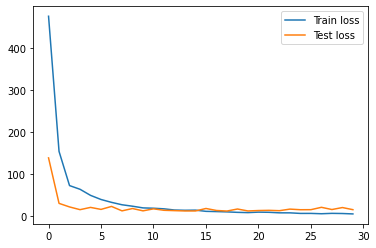

In [197]:
plt.plot(history5.history['loss'], label='Train loss')
plt.plot(history5.history['val_loss'], label='Test loss')
plt.legend();

In [199]:
ypreds5 = model5.predict(test_sequences)

In [201]:
ypreds5

array([[13.300135 ],
       [13.12348  ],
       [12.323835 ],
       [15.008747 ],
       [16.302668 ],
       [14.642952 ],
       [15.997936 ],
       [16.65906  ],
       [14.106563 ],
       [14.070362 ],
       [14.449635 ],
       [17.351585 ],
       [15.223456 ],
       [17.78287  ],
       [16.171146 ],
       [12.368638 ],
       [13.235905 ],
       [14.697697 ],
       [16.443235 ],
       [15.844976 ],
       [15.31185  ],
       [14.242605 ],
       [20.645697 ],
       [16.965229 ],
       [14.366247 ],
       [13.916821 ],
       [12.746777 ],
       [14.312151 ],
       [19.649841 ],
       [28.898949 ],
       [38.82285  ],
       [38.00263  ],
       [33.397434 ],
       [36.73553  ],
       [28.261364 ],
       [27.288342 ],
       [25.230042 ],
       [19.118444 ],
       [16.211956 ],
       [23.132978 ],
       [26.752937 ],
       [26.00742  ],
       [22.807096 ],
       [17.181423 ],
       [14.93339  ],
       [15.751947 ],
       [15.802849 ],
       [12.65

In [202]:
y_test.shape

(790,)

In [203]:
type(y_test)

numpy.ndarray

In [204]:
newy = y_test.tolist()

In [205]:
type(newy)

list

In [206]:
newy

[19.97,
 16.83,
 13.9,
 13.37,
 13.23,
 12.11,
 11.95,
 12.25,
 12.22,
 12.12,
 12.64,
 13.74,
 15.6,
 13.44,
 12.5,
 12.13,
 12.12,
 12.56,
 13.0,
 12.51,
 13.77,
 13.39,
 12.23,
 13.71,
 13.61,
 13.49,
 12.83,
 13.02,
 13.79,
 15.25,
 19.14,
 28.03,
 40.74,
 36.02,
 30.32,
 26.1,
 26.05,
 28.43,
 31.4,
 26.09,
 25.61,
 27.8,
 24.9,
 26.23,
 24.37,
 23.2,
 24.25,
 22.54,
 21.35,
 21.14,
 22.28,
 20.14,
 22.44,
 22.13,
 23.47,
 23.62,
 27.63,
 26.83,
 24.5,
 22.55,
 20.94,
 19.54,
 19.4,
 18.4,
 17.42,
 17.08,
 16.17,
 17.67,
 18.03,
 16.05,
 15.05,
 14.98,
 15.75,
 16.7,
 14.45,
 14.46,
 15.29,
 15.43,
 14.33,
 14.61,
 15.07,
 14.15,
 14.54,
 15.51,
 15.05,
 14.33,
 16.52,
 15.29,
 16.06,
 18.37,
 20.08,
 18.16,
 18.84,
 16.85,
 16.99,
 15.47,
 15.62,
 15.93,
 15.19,
 15.12,
 16.13,
 14.67,
 15.91,
 18.11,
 14.81,
 15.84,
 17.6,
 19.61,
 19.34,
 24.39,
 22.73,
 20.95,
 17.86,
 18.94,
 20.7,
 18.7,
 16.6,
 15.57,
 15.74,
 16.91,
 16.08,
 17.29,
 18.21,
 20.7,
 19.34,
 20.59,
 24.99,
 2

In [207]:
newy = newy[: len(newy) - 3]

In [208]:
len(newy)

787

In [209]:
newy_test = np.asarray(newy)

In [210]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(newy_test, ypreds5)

16.358734274060055

In [211]:
newy_test.mean()

14.633850063532401

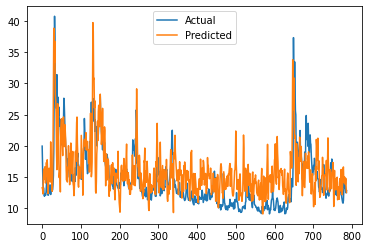

In [212]:
plt.plot(newy_test, label='Actual')
plt.plot(ypreds5, label='Predicted')
plt.legend();

This model does look to be our best model yet. We had a quicker convergence than any previous model in addition to a smaller amount of divergence afterward. The mean value of our testing data (our VIX close) was around 14.5. This model gave us an MSE of just over 16 indicating that we were on average off by around 4. This is around 30% of the value of the actual price, so it is not perfect by any means, but all things considered it is relatively close. Interestingly in all of our graphs between our predicted values and our testing values you can see that we were routinely over predicting the volatility. Specifically between around the 350th day and the 650th we are considerably higher. This happens simultaneous with the VIX being at its relative low for this time period. 